# TP2

### Introduction:
- But du TP  
- Description de la base de données   

In [1]:
import os 
import numpy as np
import zipfile
import matplotlib.pyplot as plt 
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm
import random
import sys 

%matplotlib inline 

### 1 Préparation des données

Dans un premier temps, nous allons devoir préparer les données qui permettront d’apprendre et d’évaluer notre méthode d’alignement.

##### 1.1 Téléchargement des données

In [2]:
# # Download zip file of dataset
# !wget https://cloud.isir.upmc.fr/owncloud/index.php/s/WMiMAF4aQqjoZWe/download


In [3]:
# Extract the current path
current_path = os.path.dirname(os.path.abspath('__file__'))
current_path


'c:\\Users\\Brani\\OneDrive\\Bureau\\GitHub\\Biometrics-Master-ISI-Sorbonne-University-\\PW3_alignment_of_characteristic_points_of_the_face'

In [4]:
name_dataset_file = '300w.zip'
path_dataset = os.path.join(current_path, 'data', name_dataset_file)
path_dataset

'c:\\Users\\Brani\\OneDrive\\Bureau\\GitHub\\Biometrics-Master-ISI-Sorbonne-University-\\PW3_alignment_of_characteristic_points_of_the_face\\data\\300w.zip'

In [5]:
# Unzip the downloaded file
def unzip_file(path=r'data\300w.zip'):
  zip_ref = zipfile.ZipFile(path, "r")
  zip_ref.extractall()
  zip_ref.close()

In [6]:
unzip_file(path=path_dataset)

In [7]:
def create_dataset(path_images=r'300w_train_images.txt', 
                   path_landmarks=r'300w_train_landmarks.txt'):

  
  with open(path_images) as file_images, open(path_landmarks) as file_landmarks:
    path_all_images = file_images.readlines()
    path_all_landmarks = file_landmarks.readlines()
  
  images, landmarks = [], []
  for path_image, path_landmark in tqdm(zip(path_all_images, path_all_landmarks)):
    # open method used to open different extension image file
    images.append(Image.open(path_image.strip())) 
    landmarks.append(np.loadtxt(path_landmark.strip(), dtype=float))
    
    # with open(path_landmark.strip()) as f:
    #   line = f.readlines()
    # landmarks.append([[float(l.strip().split(' ')[0]), float(l.strip().split(' ')[1])] for l in line])

  return (images, np.array(landmarks, dtype=object))

In [8]:
train_images, train_landmarks = create_dataset(path_images='300w_train_images.txt', 
                                               path_landmarks='300w_train_landmarks.txt')


3148it [00:05, 596.78it/s]


In [9]:
train_landmarks.shape

(3148, 68, 2)

In [10]:
len(train_images), len(train_landmarks)

(3148, 3148)

##### 1.2 Visualisation des données

Pour prendre en main les données, la première étape consiste à parser le fichier 300w_train_images

In [11]:
def extract_coordinates_bounding_box( image, 
                                      landmarks, 
                                      expansion_rate=0.3):
  expansion_rate /= 2
  w, h = image.size

  x_max, y_max = landmarks[:, 0].max(), landmarks[:, 1].max()
  x_min, y_min = landmarks[:, 0].min(), landmarks[:, 1].min() 

  x_max, y_max = x_max + expansion_rate*(x_max-x_min), y_max + expansion_rate*(y_max-y_min)
  x_min, y_min = x_min - expansion_rate*(x_max-x_min), y_min - expansion_rate*(y_max-y_min)

  x_max, y_max = np.clip(x_max, a_max=w, a_min=None), np.clip(y_max, a_max=h, a_min=None)
  x_min, y_min = np.clip(x_min, a_max=None, a_min=0), np.clip(y_min, a_max=None, a_min=0)

  return (x_max, y_max, x_min, y_min)


def vew_images( images, 
                landmarks=None, 
                nb_images=16,
                random_display=True, 
                grid=False, 
                total_cols=4, 
                s=5, 
                bounding_box=True, 
                color='red', 
                expansion_rate=0.3, 
                figsize=(10, 10)):
                
  # read random images
  if random_display:
    indexes = random.sample(range(len(images)), nb_images)
  else: 
    indexes = range(nb_images)


  # compute number of cols & row  
  total_cols = min(nb_images, total_cols)
  total_rows = int(nb_images / total_cols) + (1 if nb_images % total_cols != 0 else 0)

  # Create a grid of subplots.
  fig, axes = plt.subplots(total_rows, total_cols, figsize=figsize)

  # Create list of axes for easy iteration.
  if isinstance(axes, np.ndarray):
      # https://stackoverflow.com/questions/46862861/what-does-axes-flat-in-matplotlib-do
      list_axes = list(axes.flat)
  else:
      list_axes = [axes]
  # it will helps to show total images as grid 
  for nb_ax, rand_id in zip(range(nb_images), indexes):
      img = images[rand_id].copy() 
      ld_marks = landmarks[rand_id].copy()

      if ld_marks.all() != None:
        list_axes[nb_ax].scatter(ld_marks[:, 0], ld_marks[:, 1], s=s)
      
      if bounding_box:
        x_max, y_max, x_min, y_min = extract_coordinates_bounding_box(img, ld_marks, expansion_rate)
        ImageDraw.Draw(img).rectangle([(x_max, y_max), (x_min, y_min)], outline=color, width=5)
      
      list_axes[nb_ax].imshow(img, cmap='gray')
      list_axes[nb_ax].grid(grid)
      list_axes[nb_ax].set_axis_off()
      # list_axes[i].set_title(f'label {label}')

 




 




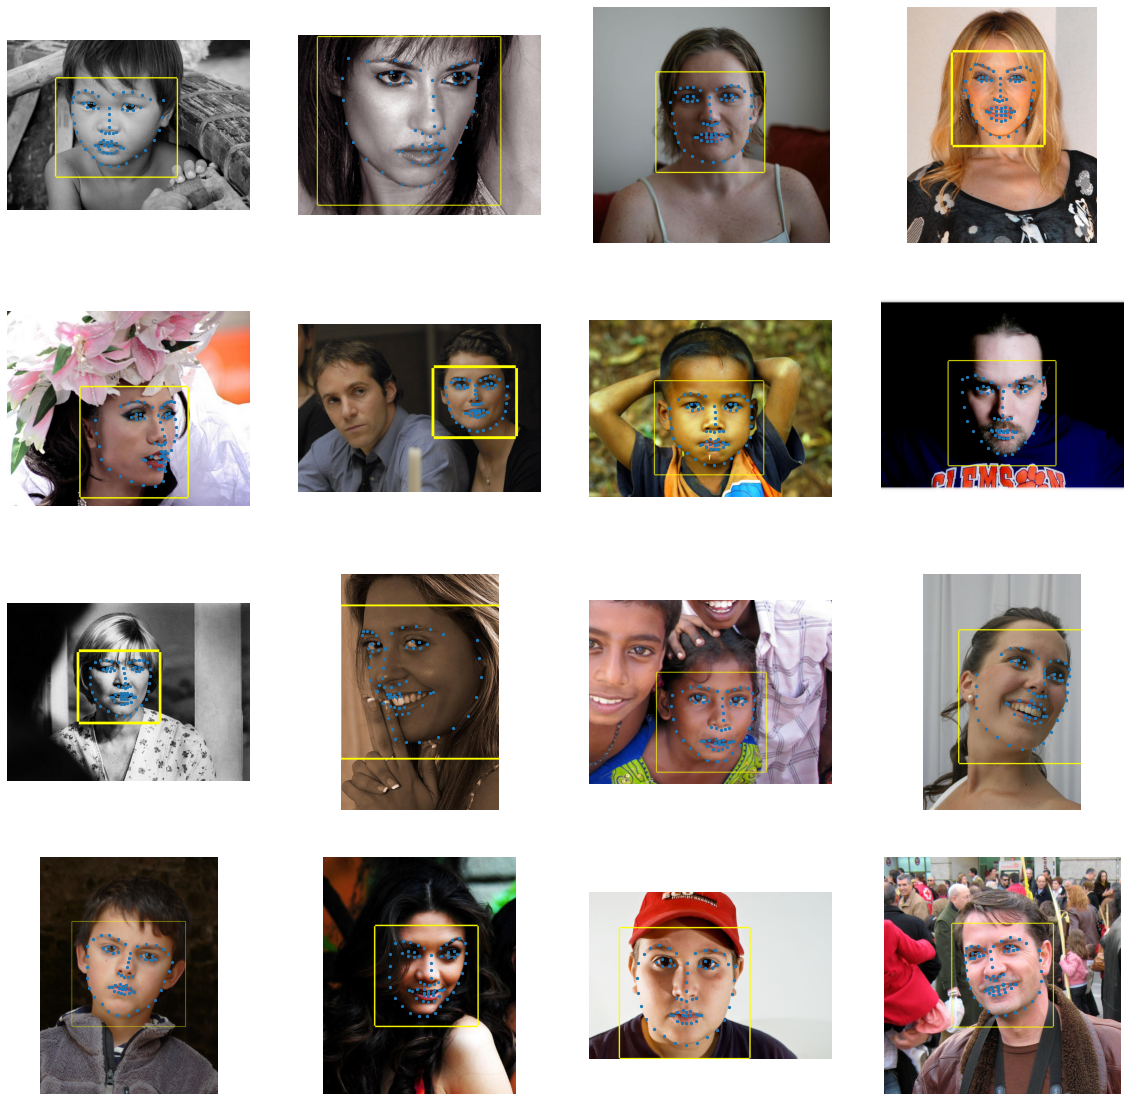

In [12]:
vew_images( images=train_images, 
            landmarks=train_landmarks, 
            nb_images=16,
            random_display=True, 
            grid=False, 
            total_cols=4, 
            s=5, 
            bounding_box=True, 
            color='yellow', 
            expansion_rate=0.3, 
            figsize=(20, 20)    )

Pour chaque image de l’ensemble d’apprentissage, vous devez :
1. Calculer les paramètres de la boite englobante des points caractéristiques du visage
1
2. Elargir cette boîte englobante de 30%, découper l’image avec ces nouvelles dimensions,
redimensionner l’image en 128 ∗ 128 et enregistrer l’image.
3. Calculer les coordonnées des points caractéristiques pour cette nouvelle image. La position
des points constituera la vérité terrain (vous afficherez l’image et les points caractéristiques
pour vérifier que ce prétraitement est effectif)
4. Calculer la position moyenne des points caractéristique sur l’ensemble des images de la
base d’apprentissage
5. Générer 10 perturbations aléatoires de la position des points caractéristiques (en translation et en facteur d’échelle) et enregistrer chacune de ces réalisations. L’amplitude de
ces déformations sera de ±20% pour le facteur d’échelle et ±20px pour les translations
(indépendamment en x et y). Pourquoi applique-t-on ces transformations ? Proposer une
méthode automatique pour déterminer l’amplitudes de ces déplacements ?
A la fin de cette étape vous disposez des données d’apprentissage dont vous aurez besoin
pour apprendre votre modèle. Il faut appliquer les mêmes transformations aux images de test
(sans les perturbations aléatoires) afin d’être dans les mêmes conditions pour l’évaluation.

In [16]:
# from skimage.transform import rescale, resize, downscale_local_mean


def create_usable_dataset(images, 
                          landmarks, 
                          registration_root_path, 
                          name_folder, 
                          expansion_rate=0.3): 

  registration_path = os.path.join(registration_root_path, name_folder) 
  try : 
    os.mkdir(os.path.join(registration_path))
  except FileExistsError as e:
    print(e), sys.exit()
  
  for i, img, ld_marks in tqdm(zip(range(len(images)), images, landmarks)):
    w, h = img.size

    x_max, y_max, x_min, y_min = extract_coordinates_bounding_box(img, ld_marks, expansion_rate)
    
  
    img = img.crop((x_min, y_min, x_max, y_max)).resize((128, 128))
    # w2, h2 = img.size

    # ld_marks[:, 0], ld_marks[:, 1] = ld_marks[:, 0] - x_min, ld_marks[:, 1] - y_min
    # ld_marks[:, 0], ld_marks[:, 1] = ld_marks[:, 0] * w2/(x_max-x_min), ld_marks[:, 1] * h2/(y_max-y_min)

    img.save(os.path.join(registration_path, "sample_{}.png".format(i)))
    # np.savetxt(os.path.join(registration_path, f'sample_{i}.pts'), ld_marks)
    
    # if i >= 50 : break

  


In [17]:
create_usable_dataset(images=train_images.copy(), 
                      landmarks=train_landmarks.copy(), 
                      registration_root_path='.', 
                      name_folder='new_dataset', 
                      expansion_rate=0.3)

1381it [01:38, 13.99it/s]


MemoryError: 

In [15]:
def extract_file_path_dataset(path_dataset, 
                              name_backup_folder):
  try : 
    os.mkdir(os.path.join(name_backup_folder))
  except FileExistsError as e:
    print(e), sys.exit()

  path_images, path_landmarks = [], []
  for file_name in os.listdir(path_dataset):
    if file_name.endswith(('.png', '.jpg', '.jpeg')):
      path_images.append(os.path.join(path_dataset, file_name))
    if file_name.endswith('.pts'):
      path_landmarks.append(os.path.join(path_dataset, file_name))

  with open(os.path.join(name_backup_folder, '300w_train_images.txt'), 'w') as fi, \
       open(os.path.join(name_backup_folder, '300w_train_landmarks.txt'), 'w') as fl:
    for pth_img, pth_ldmks in zip(path_images, path_landmarks):
        # write each item on a new line
        fi.write(f"{pth_img}\n")
        fl.write(f"{pth_ldmks}\n")
   

In [16]:
extract_file_path_dataset(path_dataset=r'new_dataset', 
                          name_backup_folder=r'paths_of_new_dataset')

In [17]:
new_train_images, new_train_landmarks = create_dataset(path_images=os.path.join(current_path, r'paths_of_new_dataset\300w_train_images.txt'), 
                                                       path_landmarks=os.path.join(current_path, r'paths_of_new_dataset\300w_train_landmarks.txt'))


51it [00:00, 161.86it/s]


In [18]:
new_train_landmarks.shape

(51, 68, 2)

In [19]:
len(new_train_images)

51

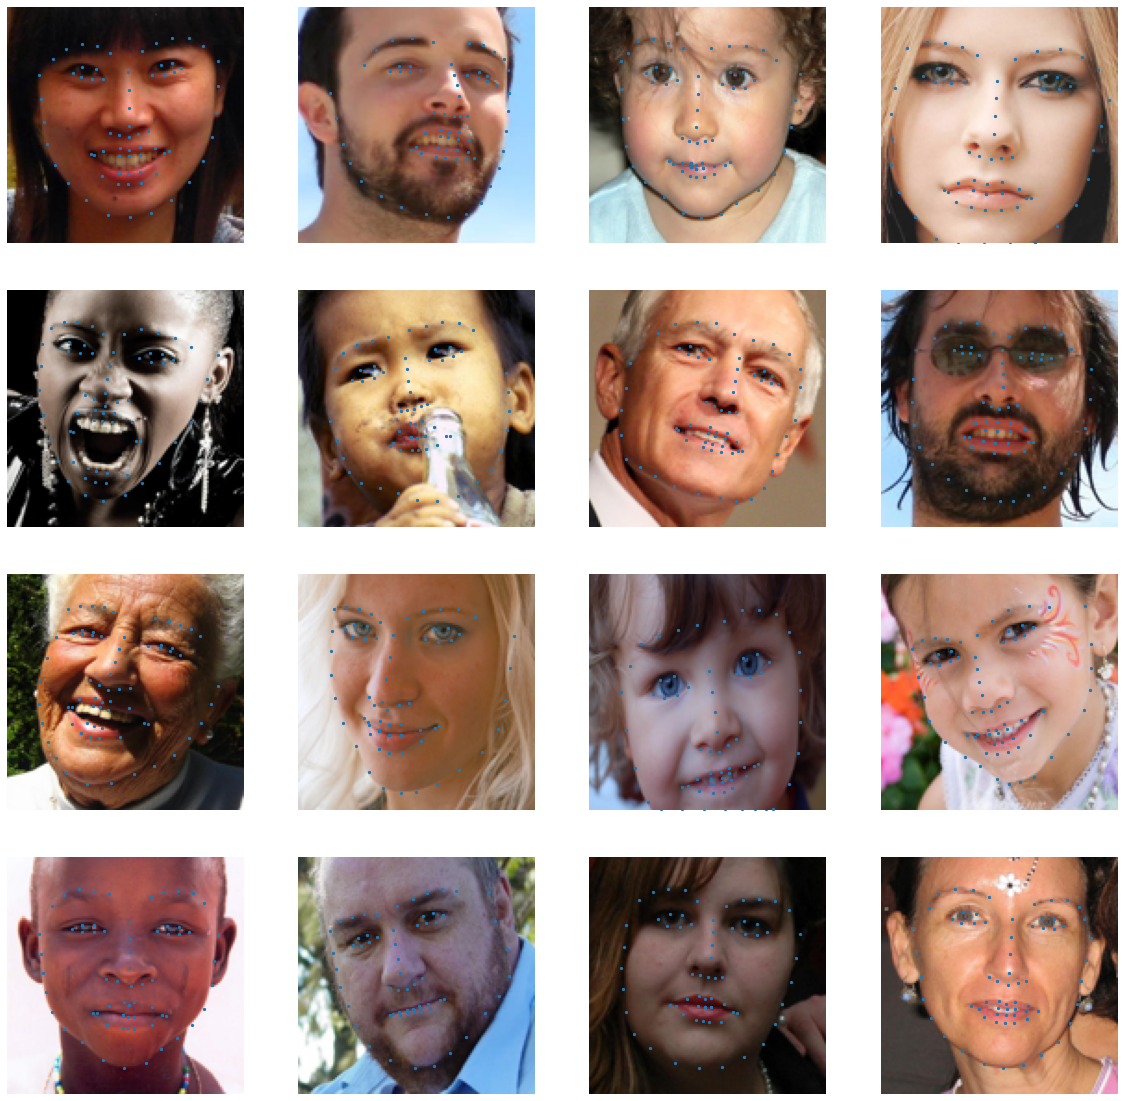

In [20]:
vew_images( images=new_train_images, 
            landmarks=new_train_landmarks, 
            nb_images=16,
            random_display=True, 
            grid=False, 
            total_cols=4, 
            s=5, 
            bounding_box=False, 
            color='yellow', 
            expansion_rate=0.3, 
            figsize=(20, 20))

In [21]:
new_train_images[0].size

(128, 128)

In [22]:
def generation_of_disturbed_data( images, 
                                  landmarks, 
                                  full_path, 
                                  name_folder, 
                                  disruption_factor=(-20, 20), 
                                  expansion_rate=0.0, 
                                  nb_disturbances=10): 

  registration_path = os.path.join(full_path, name_folder) 
  try : 
    os.mkdir(os.path.join(registration_path))
  except FileExistsError as e:
    print(e), sys.exit()
  
  min_disruption, max_disruption = disruption_factor 
  
  for i, img, ld_marks in tqdm(zip(range(len(images)), images, landmarks)):
    img_= img.copy()
    ld_ = ld_marks.copy()

    w, h = img_.size
    x_max, y_max, x_min, y_min = extract_coordinates_bounding_box(img_, ld_, expansion_rate)

    for j in range(nb_disturbances):
      scale_rate = np.random.randint(min_disruption, max_disruption) / 100 
      translation_rate = (np.random.randint(min_disruption, max_disruption), 
                          np.random.randint(min_disruption, max_disruption))

      x_translation = ld_[:, 0] + translation_rate[0]
      y_translation = ld_[:, 1] + translation_rate[1]

      if  np.all(x_translation >= 0) and np.all(x_translation < w):
        ld_[:, 0] = x_translation
      if  np.all(y_translation >= 0) and np.all(y_translation < h):
        ld_[:, 1] =  y_translation
      
      scale_transforamtion = ld_ - (ld_ * scale_rate)

      if  np.all(scale_transforamtion[:, 0] >= 0)  and np.all(scale_transforamtion[:, 0] < w) and \
          np.all(scale_transforamtion[:, 1] >= 0)  and np.all(scale_transforamtion[:, 1] < h):
        ld_ = scale_transforamtion 

      img_.save(os.path.join(registration_path, "sample_{}{}.png".format(i, j)))
      np.savetxt(os.path.join(registration_path, f'sample_{i}{j}.pts'), ld_)

    if i == 10: break
  


In [24]:
generation_of_disturbed_data(   images=new_train_images, 
                                landmarks=new_train_landmarks, 
                                full_path='.', 
                                name_folder='data_disturbed', 
                                disruption_factor=(-20, 20), 
                                expansion_rate=0.0,
                                nb_disturbances=10  )

10it [00:00, 12.10it/s]


In [25]:
extract_file_path_dataset(path_dataset=r'data_disturbed', name_backup_folder=r'paths_of_data_disturbed')

In [26]:
train_images_disturbed, train_landmarks_disturbed = create_dataset(path_images=r'paths_of_data_disturbed\300w_train_images.txt', 
                                                                  path_landmarks=r'paths_of_data_disturbed\300w_train_landmarks.txt')

110it [00:01, 91.44it/s]


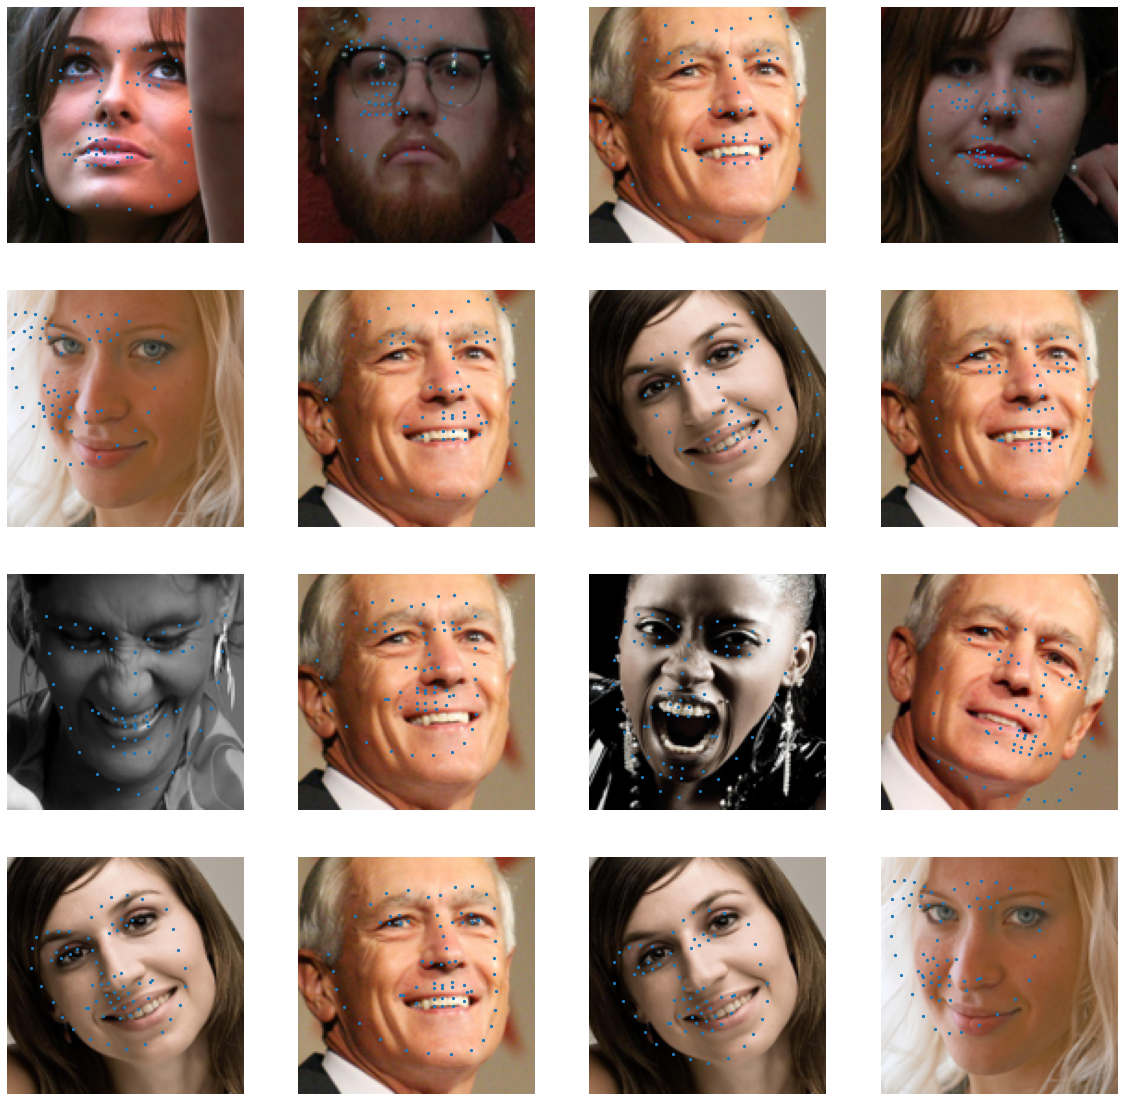

In [29]:
vew_images( images=train_images_disturbed, 
            landmarks=train_landmarks_disturbed, 
            nb_images=16,
            random_display=True, 
            grid=False, 
            total_cols=4, 
            s=5, 
            bounding_box=False, 
            color='yellow', 
            expansion_rate=0.3, 
            figsize=(20, 20))

In [28]:
np.random.randint(-20, 20)

-20